In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
sizes = [14, 100, 40, 4]

biases = pd.read_csv('b-100-40-4.csv', header=None, index_col=0)
biases = np.array(biases)
biases = [x[~np.isnan(x)] for x in biases]

weights = pd.read_csv('w-100-40-4.csv', header=None, index_col=0)

weights = np.array(weights)
weights = np.array_split(weights, np.cumsum(sizes)[:-2])


for i in range(len(weights)):
    nan_mask = np.isnan(weights[i])
    weights[i] = weights[i][~nan_mask]


    
weights = [weights[i].reshape(sizes[i], sizes[i+1]) for i in range(len(sizes[:-1]))]

In [3]:
[type(weight) for weight in weights]

[numpy.ndarray, numpy.ndarray, numpy.ndarray]

In [4]:
class NeuralNet:
    class Relu:
        def forward(self, z):
            return np.maximum(0, z)
        
        def backward(self, z):
            return np.where(z > 0, 1, 0)  
        
    def __init__(self, sizes, weights, biases, epochs=10, learning_rate=0.001):
        self.sizes = sizes
        self.layers = len(sizes)
        self.epochs = epochs
        self.lr = learning_rate
        self.params = self.initialize(weights, biases)
        self.activ = self.Relu()
        self.epoch = []
        self.train_cost = []
        self.test_cost = []
        self.train_accuracy = []
        self.test_accuracy = []
        
        
    def initialize(self, weights, biases):
        params = {}
        for i in range(1, self.layers):
            params[f'W{i}'] = weights[i - 1]
            params[f'b{i}'] = biases[i - 1]
        return params
    
    def softmax(self, z):
        max_z = np.max(z, axis=0, keepdims=True)
        expz = np.exp(z - max_z)
        return expz / np.sum(expz, axis=0, keepdims=True)

    
    def loss(self, y_true, y_pred):
        num_samples = len(y_true)
        epsilon = 1e-10  # Small epsilon value to avoid log(0)
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / num_samples
        return loss

    
    def forward(self, X):
        params = self.params
        cache = {}
        A = X.T
        for i in range(1, self.layers):
            func = self.softmax if i == self.layers - 1 else self.activ.forward
            Z = params[f'W{i}'].T.dot(A) + params[f'b{i}']
            A = func(Z)
            
            cache[f'W{i}'] = params[f'W{i}']
            cache[f'A{i}'] = A
            cache[f'Z{i}'] = Z
            
        return A, cache
       
    
    def backward(self, X, y, cache):
        d_ = {}
        cache['A0'] = X
        dZ = cache[f'A{self.layers - 1}'] - y
        dW = np.outer(cache[f'A{self.layers - 2}'], dZ)
        
        dA_ = cache[f'W{self.layers - 1}'].dot(dZ)
        
        d_[f'dW{self.layers - 1}'] = dW
        d_[f'db{self.layers - 1}'] = dZ
        
        for l in range(self.layers - 2, 0, -1):
            der = self.activ.backward(cache[f'Z{l}'])
            dZ = dA_ * der
            dW = np.outer(dZ, cache[f'A{l - 1}'])
            
            dA_ = cache[f'W{l}'].dot(dZ) if l > 1 else {}
                
            d_[f'dW{l}'] = dW.T
            d_[f'db{l}'] = dZ
            
        return d_
            
    def train(self, X_train, y_train, X_test, y_test):
        num_samples = len(X_train)
        for epoch in range(self.epochs):
            total_correct = 0
            loss = 0
            for i in range(len(X_train)):
                X = X_train[i]
                y = y_train[i]
                
                y_pred, cache = self.forward(X)
                
                train_loss = self.loss(y, y_pred)
                loss += train_loss
                
                gradients = self.backward(X, y, cache)
                
                self.gradient_descent_step(gradients)
                
                predicted_class = np.argmax(y_pred)
                true_class = np.argmax(y)
                if predicted_class == true_class:
                    total_correct += 1
                
            test_loss, test_accuracy = self.evaluate(X_test, y_test)
            self.epoch.append(epoch + 1)
            self.train_cost.append(loss / len(X_train))
            self.test_cost.append(test_loss)
            self.test_accuracy.append(test_accuracy)
            self.train_accuracy.append((total_correct / num_samples) * 100.0)
            
            
                
            print(f"Epoch {epoch+1}/{self.epochs}, Train loss: {train_loss:.4f}, Train accuracy: {(total_correct / num_samples * 100.0):.4f}%, Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}%")


    def gradient_descent_step(self, gradients):
        for i in range(1, self.layers):
            self.params[f'W{i}'] -= self.lr * gradients[f'dW{i}']
            self.params[f'b{i}'] -= self.lr * gradients[f'db{i}']

    def evaluate(self, X_test, y_test):
        num_samples = len(X_test)
        total_test_loss = 0
        total_correct = 0

        for i in range(num_samples):
            X = X_test[i]
            y = y_test[i]

            y_pred, cache = self.forward(X)

            test_loss = self.loss(y, y_pred)
            total_test_loss += test_loss

            predicted_class = np.argmax(y_pred)
            true_class = np.argmax(y)
            if predicted_class == true_class:
                total_correct += 1

        average_test_loss = total_test_loss / num_samples

        test_accuracy = (total_correct / num_samples) * 100.0

        return average_test_loss, test_accuracy


In [5]:
X_train = pd.read_csv('x_train.csv', header=None).values
y_train = pd.read_csv('y_train.csv', header=None)
y_train = pd.get_dummies(y_train, columns=[0]).values


X_test = pd.read_csv('x_test.csv', header=None).values
y_test = pd.read_csv('y_test.csv', header=None)
y_test = pd.get_dummies(y_test, columns=[0]).values

In [6]:
LEARNING_RATE = 1

In [32]:
NN = NeuralNet(sizes, weights, biases, epochs=50, learning_rate=LEARNING_RATE)
    # def __init__(self, sizes, weights, biases, epochs=10, learning_rate=0.001):

In [33]:
NN.forward(X_train[0])

(array([4.40627318e-56, 8.57988820e-70, 1.84572804e-92, 1.00000000e+00]),
 {'W1': array([[ 1.08655214, -1.98744071,  1.9036324 , ..., -0.30217358,
           0.74348986, -1.28044534],
         [ 1.80982471,  0.12322588,  1.99985731, ..., -1.27342188,
          -0.32424814, -0.00368237],
         [ 1.01029217,  0.30731344,  0.87112796, ...,  0.11899082,
          -0.90852946,  0.46613842],
         ...,
         [-0.71842277,  0.11292759,  0.52140337, ..., -0.47128811,
           0.13183239,  0.64362311],
         [-0.59960604, -0.08467472,  1.50393093, ...,  0.04086657,
          -0.84833121,  1.24858057],
         [ 1.51287401, -0.73554295,  0.15683161, ..., -1.30403125,
          -0.8020395 , -0.20315255]]),
  'A1': array([0.        , 0.        , 0.        , 3.62366354, 0.        ,
         0.        , 4.34766513, 0.        , 0.83320102, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 2.73521529, 0.        , 7.80695925, 0.        

In [34]:
NN.backward(X_train[0], y_train[0], NN.forward(X_train[0])[1])

{'dW3': array([[2.75493283e-54, 5.36440088e-68, 1.15400398e-90, 0.00000000e+00],
        [8.55790192e-55, 1.66639332e-68, 3.58478898e-91, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.55493080e-54, 4.97495724e-68, 1.07022584e-90, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.93336366e-55, 5.71184110e-69, 1.22874623e-91, 0.00000000e+00],
        [1.88263772e-56, 3.66586921e-70, 7.88611394e-93, 0.00000000e+00],
        [4.27556550e-55, 8.32537441e-69, 1.79097637e-91, 0.00000000e+00],
        [7.36111908e-55, 1.43335595e-68, 3.08347289e-91, 0.00000000e+00],
        [5.85985059e-56, 1.14102918e-69, 2.45461189e-92, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.48592208e-55, 1.26293773e-68, 2.71686475e-91, 0.00000000e+00],
        [2.75640886e-55, 5.36727498e-69, 1.15462226e-91, 0.00000000e+00],
        [0.00000000e+00, 0.0000

In [35]:
NN.train(X_train, y_train, X_test, y_test)

Epoch 1/50, Train loss: 0.4110, Train accuracy: 32.4865%, Test loss: 0.3174, Test accuracy: 37.0461%
Epoch 2/50, Train loss: 0.8511, Train accuracy: 39.0936%, Test loss: 0.2920, Test accuracy: 47.1163%
Epoch 3/50, Train loss: 1.2387, Train accuracy: 50.0191%, Test loss: 0.2303, Test accuracy: 60.2075%
Epoch 4/50, Train loss: 0.7089, Train accuracy: 67.2084%, Test loss: 0.1956, Test accuracy: 69.8810%
Epoch 5/50, Train loss: 0.6511, Train accuracy: 76.0586%, Test loss: 0.1701, Test accuracy: 71.0101%
Epoch 6/50, Train loss: 0.5613, Train accuracy: 80.3006%, Test loss: 0.1415, Test accuracy: 79.4629%
Epoch 7/50, Train loss: 0.7132, Train accuracy: 82.6200%, Test loss: 0.1502, Test accuracy: 77.9677%
Epoch 8/50, Train loss: 0.3984, Train accuracy: 84.3137%, Test loss: 0.1211, Test accuracy: 81.5685%
Epoch 9/50, Train loss: 0.4770, Train accuracy: 84.8936%, Test loss: 0.1657, Test accuracy: 80.7446%
Epoch 10/50, Train loss: 0.3097, Train accuracy: 85.2903%, Test loss: 0.1561, Test accuracy

In [14]:
train_cost = NN.train_cost
test_cost = NN.test_cost
train_accuracy = NN.train_accuracy
test_accuracy = NN.test_accuracy
epoch = NN.epoch

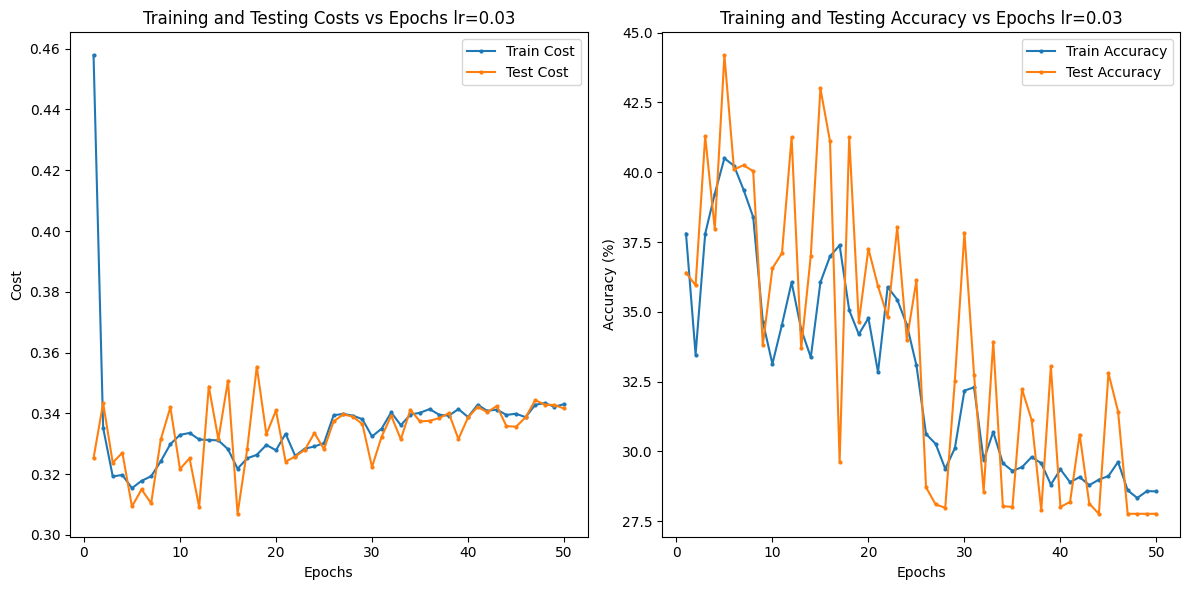

In [15]:
train_cost = NN.train_cost
test_cost = NN.test_cost
train_accuracy = NN.train_accuracy
test_accuracy = NN.test_accuracy
epochs = NN.epoch


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_cost, label='Train Cost', marker='o', markersize=2)
plt.plot(epochs, test_cost, label='Test Cost', marker='o', markersize=2)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title(f'Training and Testing Costs vs Iteration (Learning Rate{LEARNING_RATE})')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o', markersize=2)
plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='o', markersize=2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Testing Accuracy vs Iteration (Learning Rate{LEARNING_RATE})')
plt.legend()

plt.tight_layout()

# plt.savefig(f'plot-{LEARNING_RATE}.png')
plt.show()